In [1]:
from pathlib import Path
from cc_model.load_datasets import load_gt_dataset_cached


import graph_tool.all as gt
from cc_model.wl import WL, labelings_are_equivalent
from cc_model.fast_graph import FastGraph
import numpy as np
from datetime import datetime
import pickle
import matplotlib.pyplot as plt

In [2]:
# Code that should make matplotlib use ACM font (libertine)
import matplotlib

rc_fonts = {
    "font.family": "serif",
    "font.size": 20,
    'figure.figsize': (5, 3),
    "text.usetex": True,
    'text.latex.preamble': 
        r"""
        \usepackage{libertine}
        \usepackage[libertine]{newtxmath}
        """,
}
matplotlib.rcParams.update(rc_fonts)

In [3]:
datasets = [#"karate", 
#            "phonecalls",
            "HepPh", 
#            "AstroPh", 
#            "web-Google",
#             "soc-Pokec"
#            "deezer_HR", "deezer_HU", "deezer_RO","tw_musae_DE",
#            "tw_musae_ENGB","tw_musae_FR","lastfm_asia","fb_ath",
#            "fb_pol", "facebook_sc"
           ]

In [4]:
dataset_path = Path("/home/felix/projects/colorful_configuration/datasets")

In [5]:
epsilon=1e-16
max_iter = 1200
alpha=0.85

In [6]:
def rewire_run_pagerank_for_round(G, depth, in_base_pagerank, number_of_rewires=10, verbosity=0):
    """ Calculate similarities in pagerank vectors for rewired G
    G :      FastGraph
    depth:    depth of WL iteration to be used
    in_base_pagerank :    in pagerank of G
    Generate synthethic networks which have the same WL colors as G
      at specific depth and return absolute error sum
    """
    pagerank_args = {"mode":"in",
                     "epsilon":epsilon,
                     "max_iter":max_iter,
                     "alpha":alpha,
                     "return_err":True}
    
    errors = []
    for i in range(number_of_rewires):
        G.rewire(depth)
        
        in_pagerank, err = G.calc_pagerank(**pagerank_args)
        
        if verbosity > 0:
            print("the error in pagerank is:\r\n", err)
        if err < 0:
            print("did not converge!"+str(err))
        pagerank_diff = np.sum(np.abs(in_base_pagerank-in_pagerank))
        errors.append(in_pagerank)

    return errors

In [7]:
def compute_pagerank_on_all_datasets(n_rewires, verbosity=0):
    """ computes pagerank and compares it with rewired graphs
    """
    list_values = []
    list_stds = []
    for dataset in datasets:
        if dataset is None:
            list_means.append([])
            list_stds.append([])
            continue
        if verbosity > 0:
            print(dataset)
        G_base = load_gt_dataset_cached(dataset_path,
                                        dataset,
                                        verbosity=verbosity,
                                        force_reload=False)
        edges = np.array(G_base.get_edges(), dtype=np.uint32)


        
        G = FastGraph(edges, G_base.is_directed())

        values = get_SAE_for_iterations(G,
                                        n_rewires=n_rewires,)
        list_values.append(values)
    return list_values

In [8]:
glob_pagerank=None
def get_SAE_for_iterations(G, n_rewires):
    values = []
    G.ensure_edges_prepared(initial_colors="out_degree")
    print(G.dead_arr.sum(axis=1)/G._edges.shape[0])
    in_base_pagerank, _ = G.calc_pagerank("base in",
                                          epsilon=epsilon,
                                          max_iter=max_iter,
                                          alpha=alpha,
                                          return_err=True)
    global glob_pagerank
    glob_pagerank=in_base_pagerank
    
    for WL_round in range(G.wl_iterations-1,-1,-1):
        if verbosity>0:
            print("WL round", WL_round)

        SAEs = rewire_run_pagerank_for_round(G,
                                             WL_round,
                                             in_base_pagerank,
                                             number_of_rewires=n_rewires,
                                             verbosity=0)
        values.append(SAEs)
    return values

In [9]:

verbosity=1
number_of_samples = 10
list_values = compute_pagerank_on_all_datasets(number_of_samples, verbosity=1)
list_values=list_values[::-1]

HepPh
resetting
[0.03104526 0.99670049 0.99737415 0.99737415]
WL round 3
WL round 2
WL round 1
WL round 0


In [10]:
from numba import njit
@njit
def get_CDF(v, include_zero=False):
    v=v.copy()
    v.sort()
    
    max_len=len(v)
    if include_zero:
        max_len+=1
    y = np.zeros(max_len)
    x = np.zeros(max_len)
    i=0
    if include_zero:
        y[0]=len(v)
        x[0]=0
        i+=1
    count = 0
    unique_counter=0
    while i < len(v):
        last_value=v[i]
        while (i < len(v)) and (last_value==v[i]):
            i+=1
            count+=1
        y[unique_counter]=1+len(v)-count
        x[unique_counter]=last_value
        unique_counter+=1
    return x[:unique_counter], y[:unique_counter]

In [11]:
for j in range(len(list_values[0])):
    print(np.abs(list_values[0][j][0]-glob_pagerank).max())

6.624475273886432e-17
6.624475273886432e-17
2.862477553495711e-06
0.0017843249692385055


In [12]:
list_values[0]=list_values[0][::-1]

In [13]:
relative=False
dpi=200

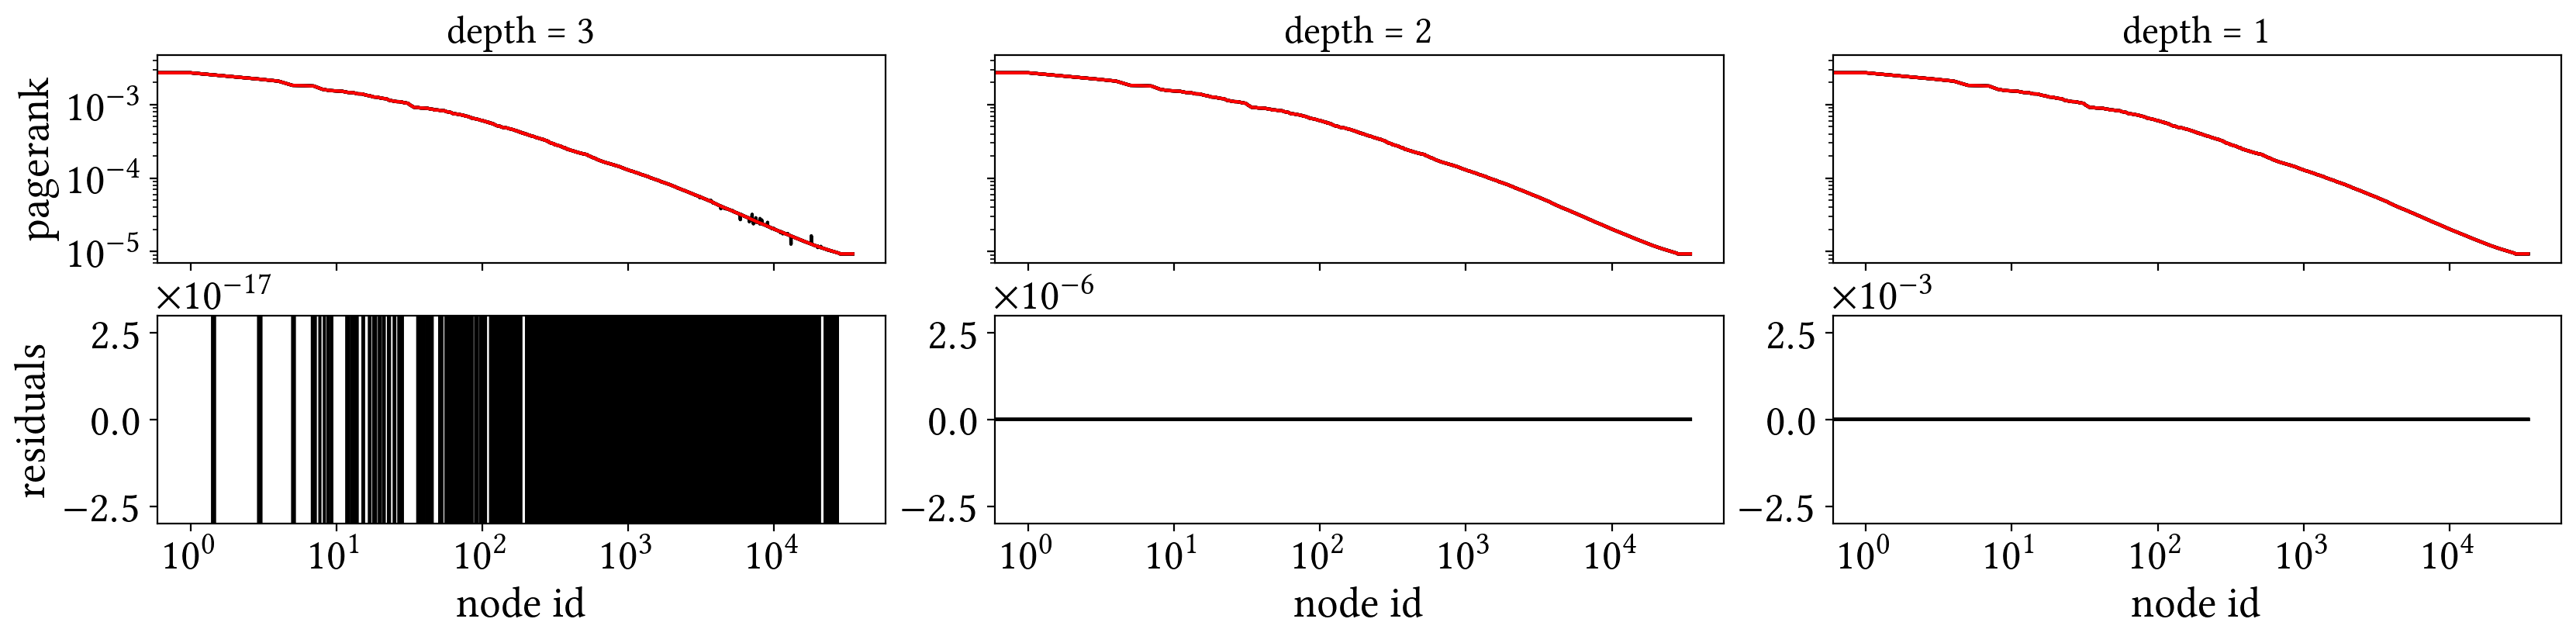

In [14]:
x=np.arange(len(glob_pagerank))[::-1]
inds= np.argsort(glob_pagerank)
y0=glob_pagerank[inds]
#plt.figure(figsize=(10,2))
max_depth=len(list_values[0])
fig, axs_all = plt.subplots(2,max_depth-1,figsize=(20,4),dpi=dpi)

axs=axs_all[0,:]
for j in range(1,max_depth):
    ax = axs[j-1]
    for arr in list_values[0][j][:5]:
        ax.plot(x,arr[inds], color="k")
        #axs[1,j].plot(x,arr[inds]-y0, color="r")
    ax.plot(x,y0, color="r")
    


    ax.set_title(f"depth = {4-j}", fontsize=18)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_yticks([1e-3,1e-4,1e-5])
    
    ax.set_xticks([1,10,100,1000,10000])
    ax.axes.xaxis.set_ticklabels([])
    if j >1:
        ax.axes.yaxis.set_ticklabels([])
    else:
        ax.set_ylabel("pagerank")
plt.subplots_adjust(wspace=0.1, hspace=0)


axs=axs_all[1,:]
the_depth = max_depth-1
#fig, axs = plt.subplots(1,the_depth,figsize=(20,3))
for j in range(1,the_depth+1):
    
    for arr in list_values[0][j][:5]:
        #axs[j].plot(x,arr[inds], color="b")
        vals = (arr[inds]-y0)
        if relative:
            #vals=np.sign(vals)*np.log(np.abs(vals/y0))
            #vals=np.log10(np.abs(vals/y0)+1e-20)
            vals = np.abs(vals)+1e-20
            #vals = vals/y0
        axs[j-1].plot(x,vals, color="k")
        d=np.max(np.abs(arr[inds]-y0))
    #axs[j].plot(x,y0, color="r")
    


    #plt.yscale("log")
    




for i in range(the_depth):
    axs[i].set_xscale("log")
    axs[i].set_xticks([1,10,100,1000,10000])
    axs[i].set_xlabel("node id")
#axs[0].set_ylim(-3e-17,3e-17)
if not relative:
    axs[0].set_ylabel("residuals")
    axs[0].set_ylim(-3e-17,3e-17)
    axs[1].set_ylim(-3e-6,3e-6)
    axs[2].set_ylim(-3e-3,3e-3)
    axs[2].ticklabel_format(axis='y', scilimits=[-2, 2])
else:
    axs[0].set_ylabel("log absolute error")
    
    #axs[0].set_ylim(-3e-13,3e-13)
    #axs[1].set_ylim(-3e-1,3e-1)
    #axs[2].set_ylim(-3e+1,3e+1)
    for i in range(3):
        axs[i].set_ylim(1e-21,100)
        axs[i].set_yticks([1e-20, 1e-9, 1e-3])
        axs[i].set_yscale("log")
        axs[i].set_yticks([1e-20, 1e-9, 1e-3])

    #axs[0].ticklabel_format(axis='y', scilimits=[0, 0])
    #axs[1].ticklabel_format(axis='y', scilimits=[0, 0])
    #axs[2].ticklabel_format(axis='y', scilimits=[0, 0])
    
#axs[0].yticks("off")
plt.subplots_adjust(wspace=0.15, hspace=0.25)

In [15]:
dpi=600

In [16]:
from matplotlib.ticker import FixedLocator, ScalarFormatter

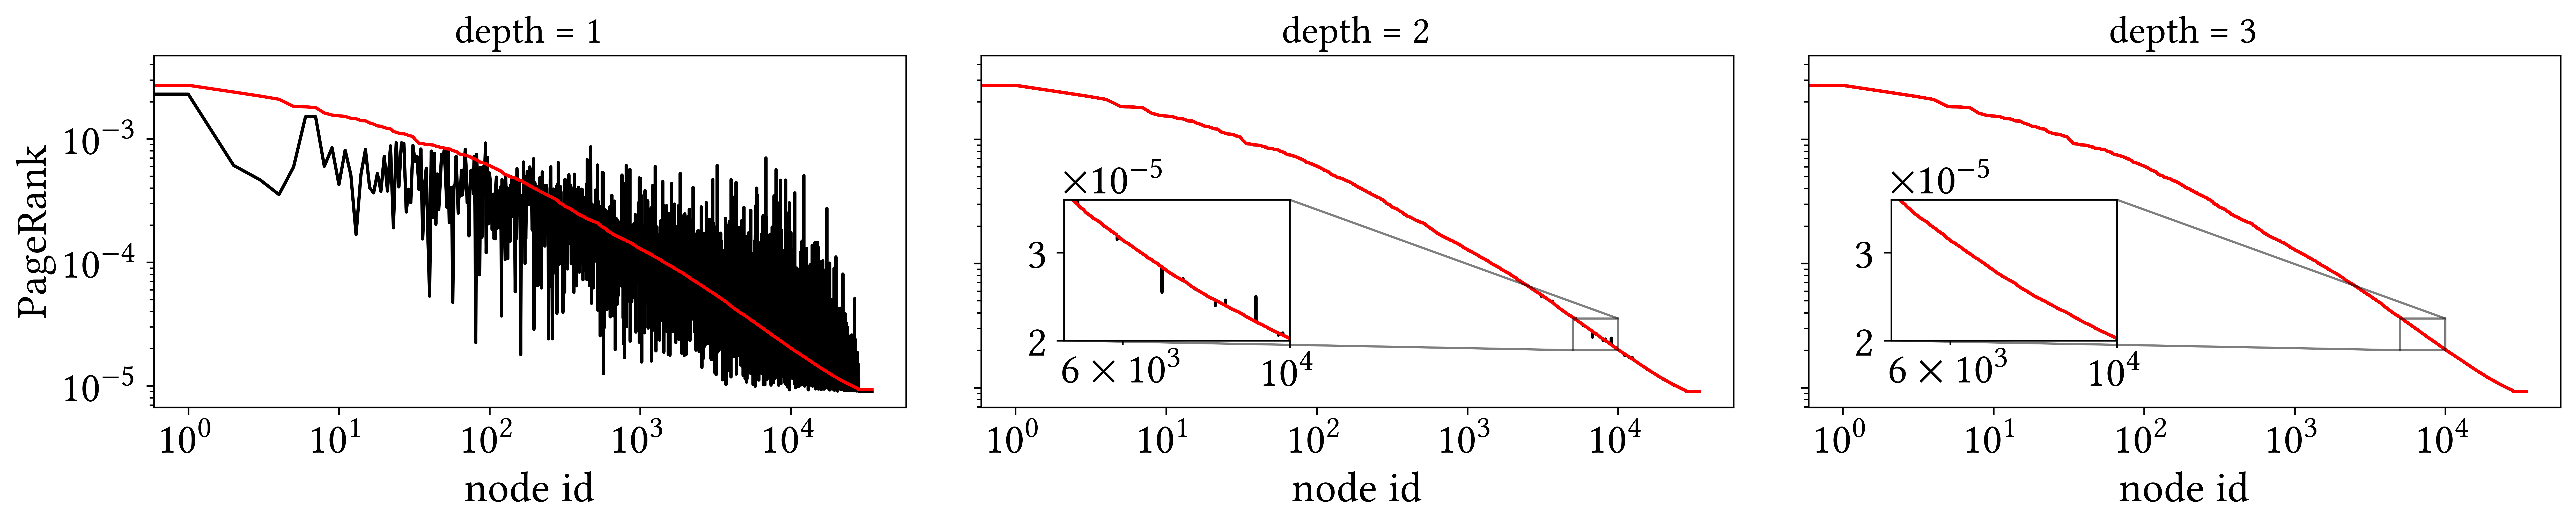

In [20]:
x=np.arange(len(glob_pagerank))[::-1]
inds= np.argsort(glob_pagerank)
y0=glob_pagerank[inds]
#plt.figure(figsize=(10,2))
max_depth=len(list_values[0])
fig, axs_all = plt.subplots(1,max_depth-1,figsize=(20,3),dpi=dpi)
num_samples = 1
axs=axs_all#[0,:]
for j in range(0,max_depth-1):
    ax = axs[j]
    for arr in list_values[0][j][:num_samples]:
        ax.plot(x,arr[inds], color="k")
        #axs[1,j].plot(x,arr[inds]-y0, color="r")
    ax.plot(x,y0, color="r")
    


    ax.set_title(f"depth = {j+1}", fontsize=18)
    ax.set_xlabel("node id")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_yticks([1e-3,1e-4,1e-5])
    
    ax.set_xticks([1,10,100,1000,10000])
    #ax.axes.xaxis.set_ticklabels([])
    if j >0:
        ax.axes.yaxis.set_ticklabels([])
    else:
        ax.set_ylabel("PageRank")
plt.subplots_adjust(wspace=0.1, hspace=0)




# inset axes....


for j in [2,3]:
    axins = axs[j-1].inset_axes([0.11, 0.19, 0.3, 0.4], xticklabels=[], yticklabels=[])
    ax = axins
    for arr in list_values[0][j-1][:num_samples]:
        ax.plot(x,arr[inds], color="k")
        #axs[1,j].plot(x,arr[inds]-y0, color="r")
    ax.plot(x,y0, color="r")
    
    
    #axins.imshow(Z2, extent=extent, origin="lower")
    # sub region of the original image
    x1, x2, y1, y2 = 10**3.7, 10**4, 2*10**-5, 3.6*10**-5
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    #axins.set_xticklabels([ 10**4])
    axins.yaxis.set_major_locator(FixedLocator([2*10**-5, 3*10**-5]))
    axins.yaxis.set_major_formatter(ScalarFormatter())
    #axins.set_yticklabels([2*10**-5, 4*10**-5])
    axins.set_xscale("log")
    #axins.set_yscale("log")
    axins.xaxis.set_minor_locator(FixedLocator([6*10**3]))
    #minorticks_off()
    #axins.ticklabel_format(axis='y', scilimits=[-2, 2])

    axs[j-1].indicate_inset_zoom(axins, edgecolor="black")


In [71]:
np.searchsorted(x[::-1], [10**3.7, 10**4])

array([ 5012, 10000])

In [73]:
tmp = y0[::-1][ 5012: 10000]
print(np.min(tmp))
print(np.max(tmp))

2.0239280961142688e-05
3.675798695979903e-05


In [68]:
for j in range(1,the_depth+1):
    print(j)
    for arr in list_values[0][j][:5]:
        print(np.argmax(arr[inds]-y0))

1
34464
34464
34464
34464
34464
2
16573
27478
27478
30861
26327
3
32162
34166
31506
34377
30844


In [52]:
np.max(x)

34545

In [56]:
x[0]

34545

In [55]:
x[1:]>x[:-1]

array([False, False, False, ..., False, False, False])

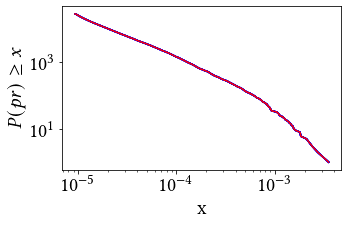

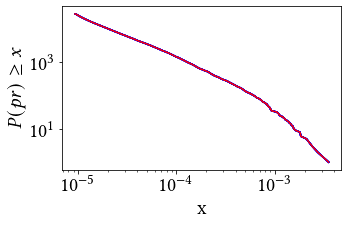

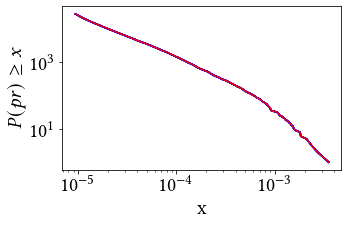

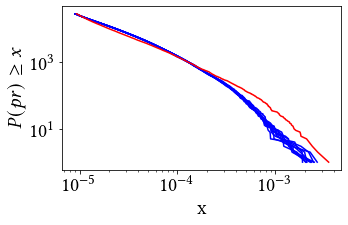

In [27]:
x,y = get_CDF(glob_pagerank)
for j in range(len(list_values[0])):
    plt.figure()
    for arr in list_values[0][j]:
        x2,y2 = get_CDF(arr)
        plt.plot(x2,y2, color="b")

    plt.plot(x,y,color="r")
    plt.xscale("log")
    plt.yscale("log")

    plt.xlabel("x")
    plt.ylabel("$P(pr)\geq x$")

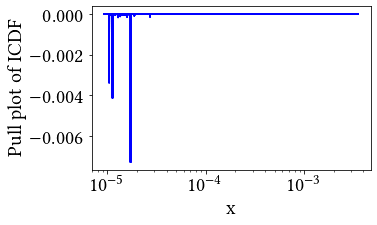

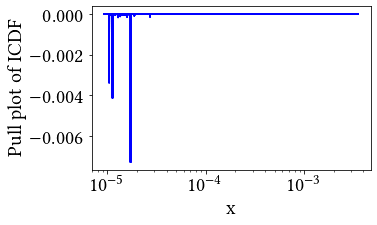

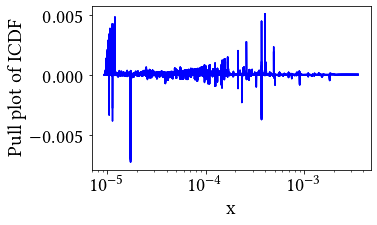

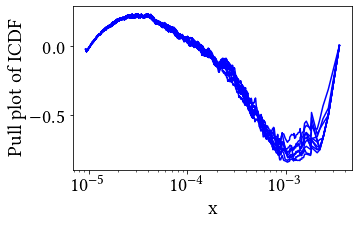

In [270]:
x,y = get_CDF(glob_pagerank)
for j in range(len(list_values[0])):
    plt.figure()
    for arr in list_values[0][j]:
        #arr=arr/np.sum(arr)
        x2,y2 = get_CDF(arr)
        y3=np.interp(x,x2,y2)
        plt.plot(x,(y3-y)/y, color="b")

    #plt.plot(x,y,color="r")
    plt.xscale("log")
    #plt.yscale("log")

    plt.xlabel("x")
    plt.ylabel("Pull plot of ICDF")

In [141]:
print()
now = datetime.now()
if number_of_samples > 10:
    save_prefix = now.strftime("%Y_%m_%d__%H_%M_%S")
    out_name = "./results/"+"_pagerank_"+save_prefix+".pkl"
    print(out_name)
    with open(out_name, "wb") as f:
        pickle.dump((list_values, datasets), f)

In [ ]:
def get_mean_std(list_values):
    list_means = []
    list_stds0 = []
    list_stds1 = []

    for values in list_values:
        mean = np.mean(values)+1e-20
        quantiles = np.quantile(values, [0.5-0.68/2, 0.5+0.68/2,])
        list_means.append(mean)
        list_stds0.append(quantiles[0])
        list_stds1.append(quantiles[1])
    list_stds = [list_stds0[::-1], list_stds1[::-1]]
    return list_means[::-1], list_stds

def quickplot(list_values, datasets, show_alpha=False, save_date=None, xlim=None):
    plt.figure(figsize=(10,6))
    if show_alpha:
        x=np.linspace(0,15)
        y=2 *alpha**(x+1)
        plt.plot(x,y)
    
    markers = [".", "o", "<", "s", "*"]
    markers2 = ["^", "o", "+", "x", "_"]
    marker_sizes = 6*np.array([1.4, 1, 1.5, 1, 1.9,])
    


    for values, label, marker, ms in zip(list_values, datasets, markers2, marker_sizes):
        means, stds = get_mean_std(values)
        plt.errorbar(x=np.arange(len(means)),y=means, yerr=stds, label=label, fmt=marker+"--", markersize=ms)


    plt.ylabel("SAE of PageRank centrality")
    plt.xlabel("depth $d$")
    if xlim is not None:
        plt.xlim(*xlim)
    plt.yscale("log")
    plt.legend()
    #
    if save_date is None:
        plt.title("Convergence of pagerank for synthetic networks ")
    else:
        time_str = save_date.strftime("%Y_%m_%d__%H_%M_%S")
        plt.savefig(Path(".")/Path('images')/f'pagerank_{time_str}.pdf', bbox_inches = 'tight')

In [ ]:
quickplot(list_values, datasets, show_alpha=False, save_date=datetime.now())

In [ ]:
load_dataset=True
if load_dataset:
    load_date = datetime(2021,12,11,3,2,49)
    save_prefix = load_date.strftime("%Y_%m_%d__%H_%M_%S")
    with open("./results/"+save_prefix+".pkl", "rb") as f:
        (list_means2, list_stds2, datasets2) = pickle.load(f)

In [ ]:
quickplot(list_means2, list_stds2, datasets2, save_date=load_date)

In [ ]:
plt.rcParams['lines.markersize']